step 1
136 136
step 2
733
step 3, Choose 1 : normalizing each graplet distribution connect k-times or Choose 2 : normalizing the resulting concatenated vector
This is choice  1
before (136, 49111)
after (136, 2037)
step 4
4 columns of all_phi with std = 0
step 5


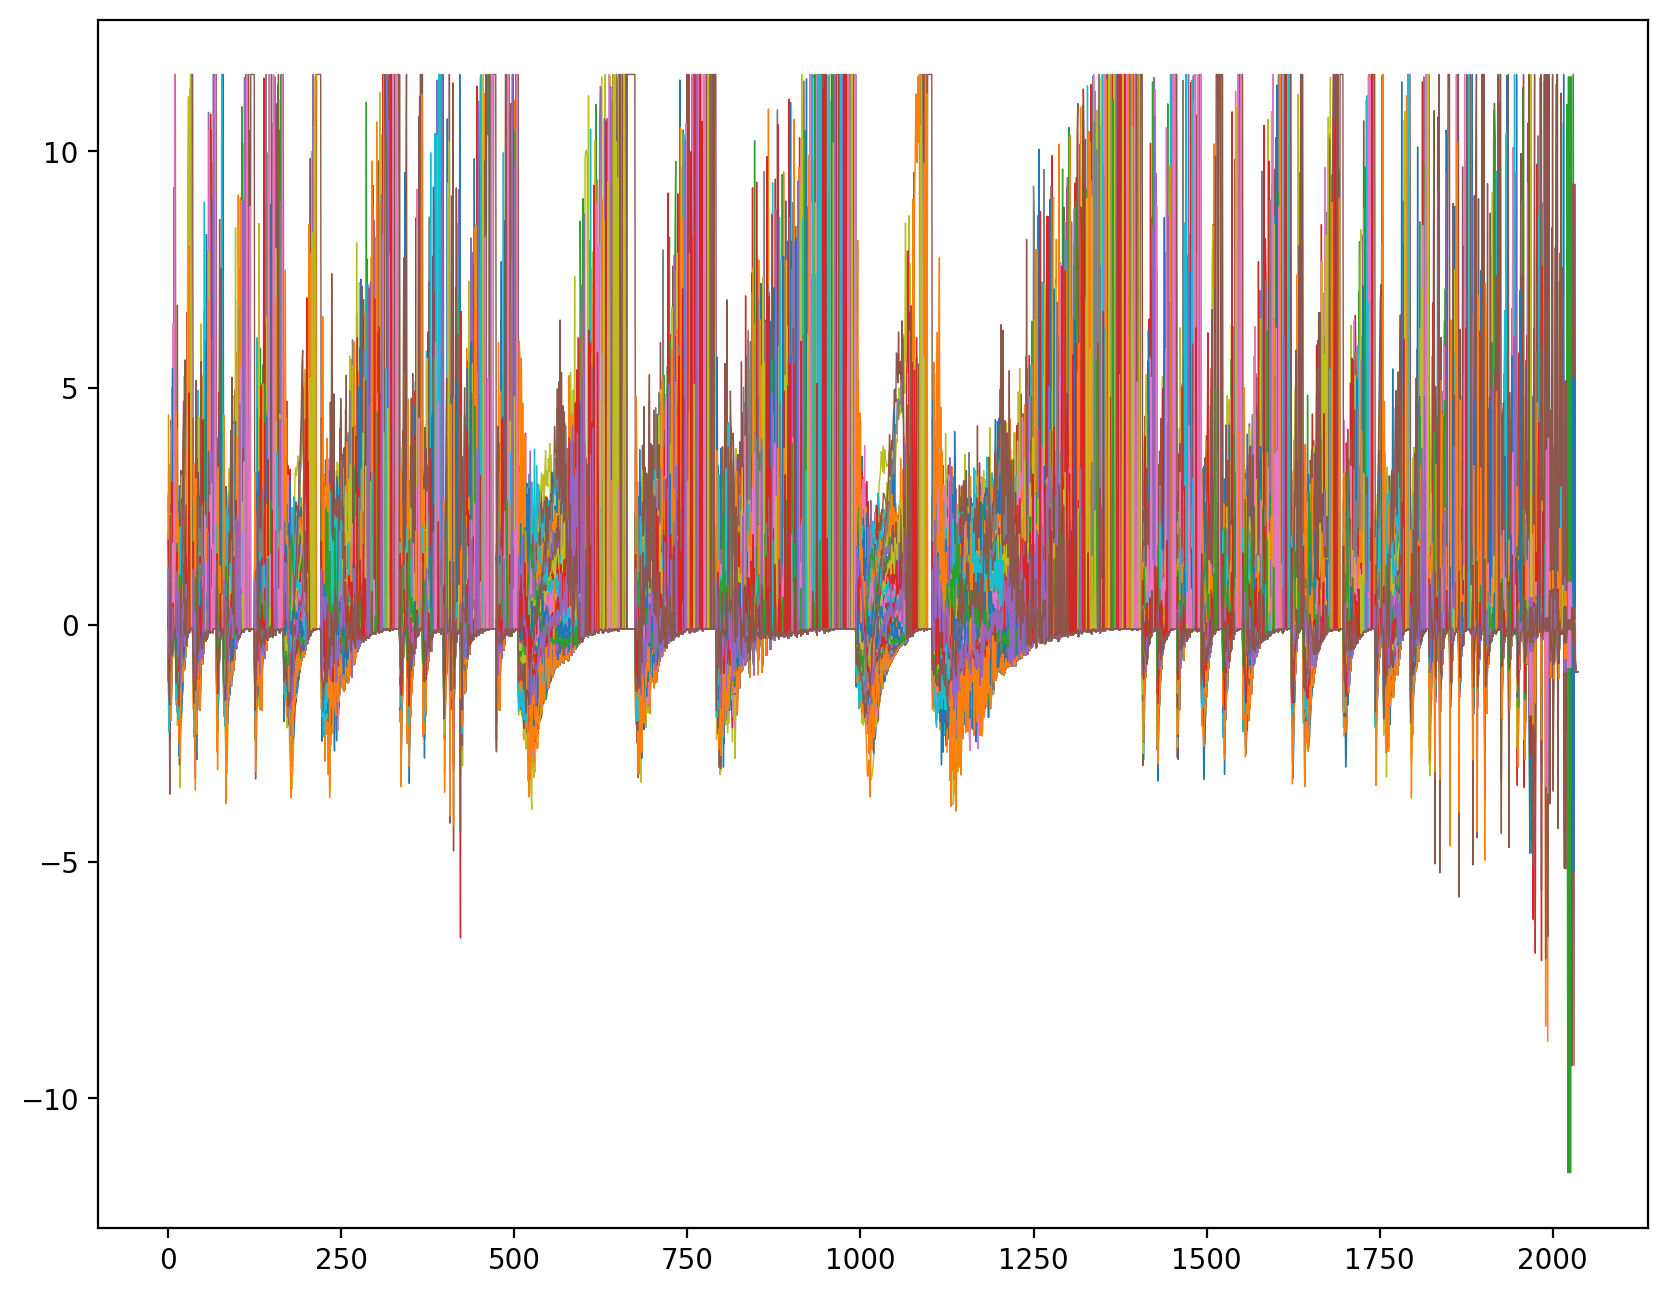

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import csv
from sklearn.decomposition import PCA

choice = 1 #choice kernel version 1 or version 2

def remove_column(entry):
    """given array, returns the array without the columns filled with zeros"""
    
    def delete_column(array, i):
        """
        given array and i-th column index
        return the array without that i-th column
        """
        array = np.delete(array, i, 1)
        return array
    
    def test_zero(array):
        """given array, return True if it contains only zeros"""
        return np.all(array == 0)
    
    array = []
    for c in range(entry.shape[1]):
        if test_zero(entry[:,c]) == False:
            array.append(entry[:,c])
    array = np.array(array).T
    return array

def hist_d(array : np.ndarray, d):
    """
    given array of integer values,
    returns the histogram of consecutive integer values without hole
    and fill with zeros until "sortie" array is of length d
    """
    bins = np.append(np.arange(0,array.max()+1)-0.5,array.max()+0.5)
    sortie = np.histogram(array, bins = bins)[0]
    sortie = np.zeros(d)
    l = len(np.histogram(array, bins = bins)[0])
    sortie[0:l] = np.histogram(array, bins = bins)[0][0:d]
    return sortie

def hist(array : np.ndarray):
    """
    given array of integer values,
    returns the histogram of consecutive integer values without hole
    """
    bins = np.append(np.arange(0,array.max()+1)-0.5,array.max()+0.5)
    return np.histogram(array, bins = bins)[0]

print("step 1")
folder_path = '/Users/endingalaporte/Desktop/orbit_degree_kernel/'

#import n cities's orbit count

n = 136

all_cities = []

input_path = '/Users/endingalaporte/Desktop/orbit_degree_kernel'+'/input/'

for i in range(n): #attention ici n graphs
    file_name = 'edgelist_city'+str(i)+'_orca_orbits.csv'
    embed_phi = pd.read_csv(input_path + file_name).to_numpy()[:,1:68]
    all_cities.append(embed_phi)

all_cities = np.array(all_cities, dtype = object)

#import n labels

label_path = input_path+'country_binary.txt'
text = open(label_path, encoding='utf-16')
reader = csv.reader(text, delimiter='\n')
labels = np.array([int(row[0]) for row in reader])
labels = labels[0:n]
print(len(labels), len(all_cities))

print("step 2")
#each graph has its orbit degree vector counted for each orbit
#we then count how many degree of each orbt exist, and we find the 
#max degree dist amongt all graphlets degree vector

max_dist = []
for j in range(n):
    for i in range(all_cities[0].shape[1]):
        max_dist.append(len(hist(all_cities[j][:,i])))
        
max_dist = np.array(max_dist)
d = max_dist.max()
print(d)
print("step 3, Choose 1 : normalizing each graplet distribution connect k-times or Choose 2 : normalizing the resulting concatenated vector")
print("This is choice ",choice)

if choice == 1:
    #Choice 1
    #normalize resulting concatenated all_phi
    all_phi = []
    for j in range(n):
        phi = []
        for i in range(all_cities[0].shape[1]):
            phi.append(hist_d(all_cities[j][:,i], d))
        phi = np.array(phi).flatten()
        all_phi.append(phi)
    all_phi = np.array(all_phi)

    #normalize each phi vector
    for i in range(n):
        all_phi[i] = all_phi[i]/all_phi[i].sum()

    #make distribution of each orbit accross all cities an empirical standard distribution
    #that way, each variation of each orbit has an equal participation to the distance or kernel

    for i in range(all_phi.shape[1]):
        if all_phi[:,i].std() != 0:
            all_phi[:,i] = (all_phi[:,i] - all_phi[:,i].mean())/all_phi[:,i].std()

    #remove columns filled only with zero
    print("before",all_phi.shape)
    all_phi = remove_column(all_phi)
    print("after",all_phi.shape)
if choice == 2:
    #Choice 2
    #normalizing each histogram of graphlet degree
    all_phi = []
    for j in range(n):
        phi = []
        for i in range(all_cities[0].shape[1]):
            h = hist_d(all_cities[j][:,i], d)
            h = h/h.sum()
            phi.append(h)
        phi = np.array(phi).flatten()
        all_phi.append(phi)
    all_phi = np.array(all_phi)


    #make distribution of each orbit accross all cities an empirical standard distribution
    #that way, each variation of each orbit has an equal participation to the distance or kernel

    for i in range(all_phi.shape[1]):
        if all_phi[:,i].std() != 0:
            all_phi[:,i] = (all_phi[:,i] - all_phi[:,i].mean())/all_phi[:,i].std()

    #remove columns filled only with zeros
    print("before",all_phi.shape)
    all_phi = remove_column(all_phi)
    print("after",all_phi.shape)

print("step 4")

#count the number c of std = 0 accross each column of all_phi
all_phi = all_phi

all_phi.shape[1]

std = []
for j in range(all_phi.shape[1]):
    std.append(all_phi[:,j].std())
std = np.array(std)

c = 0
for i in std == 0:
    if i == True:
        c = c+1
print(c,"columns of all_phi with std = 0")

print("step 5")

#visualize the phi vector of each city

output = folder_path+'output/'
plt.figure(figsize = (10,8), dpi = 200)
for i in range(len(all_phi)):
    plt.plot(all_phi[i], linewidth=0.5)
plt.savefig(output+"all_phi_standardized_normalized_hist_withoutzeros.svg")


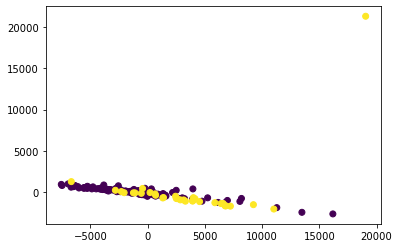

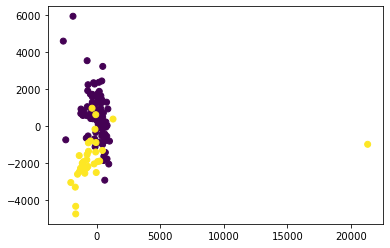

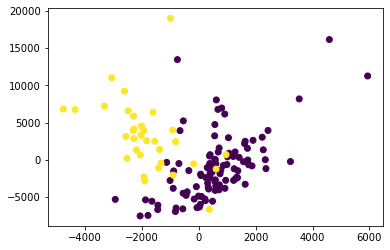

In [2]:
#kernel matrix K
K = np.zeros([n,n])
for i in range(n):
    for j in range(n):
        K[i,j] = np.dot(all_phi[i], all_phi[j])
        
#PCA using kernel matrix K

reducer = PCA(n_components = 3)
embed = reducer.fit_transform(K)
plt.scatter(embed[:,0], embed[:,1], c = labels, marker = "o")
plt.savefig(output + '12dim_pca_orbitdegree_normalized_hist_withoutzeros_standardized_kernel_'+str(n)+'cities.svg')
plt.subplots()
plt.scatter(embed[:,1], embed[:,2], c = labels, marker = "o")
plt.savefig(output + '23dim_pca_orbitdegree_normalized_hist_withoutzeros_standardized_kernel_'+str(n)+'cities.svg')
plt.subplots()
plt.scatter(embed[:,2], embed[:,0], c = labels, marker = "o")
plt.savefig(output + '30dim_pca_orbitdegree_normalized_hist_withoutzeros_standardized_kernel_'+str(n)+'cities.svg')

In [3]:
from sklearn.metrics import silhouette_score

silhouette_score(embed, labels), silhouette_score(all_phi, labels)
#(0.2654413832168706, 0.12552248010991932) normalized_hist_withoutzeros_standardized_kernel

(0.2654413832168705, 0.12552248010991912)

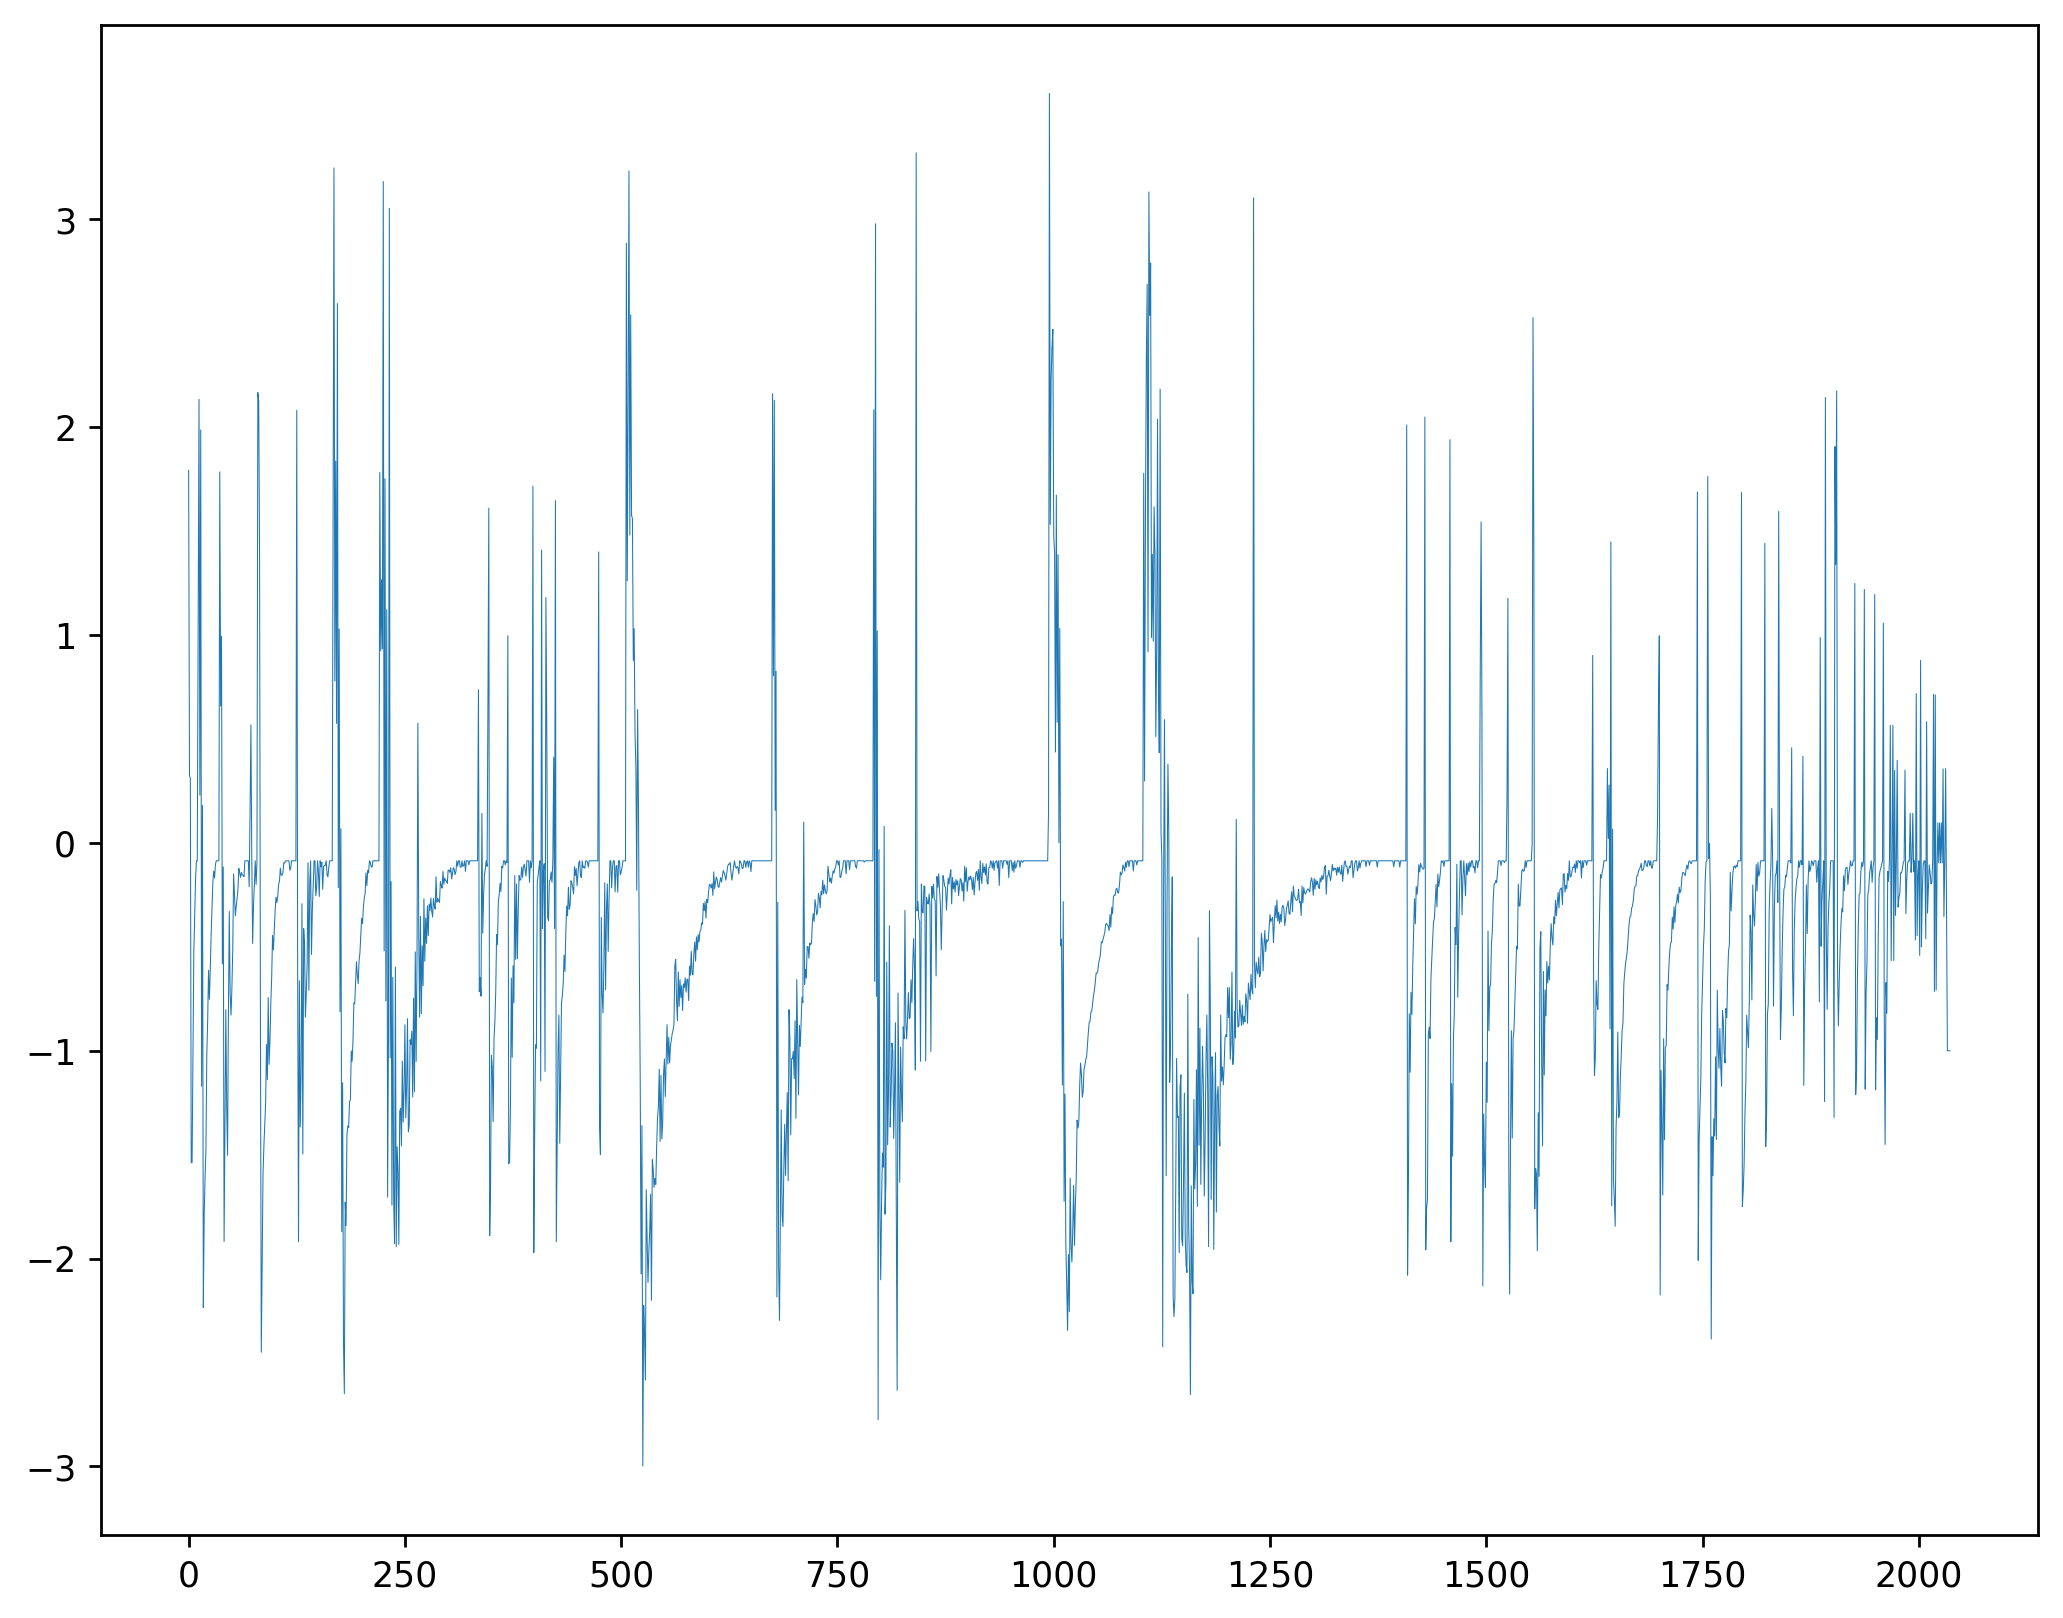

In [4]:
plt.figure(figsize = (10,8), dpi = 250)
plt.plot(all_phi[0], linewidth = 0.3)
plt.savefig(output + "phi_hist_norm_stdized_ajaccio.svg")

In [5]:
silhouette_score(all_phi, labels, metric = 'l1')

0.19434127408328383